In [1]:
from DataParser import get_df_list

# df's containing only the signals captured when the machine is touching
df_list = get_df_list()

In [2]:

import pandas as pd
import matplotlib.pyplot as plt

def alpha_trimmed_mean_filter(data: list, win_size: int, alpha: int) -> list:
    n = len(data)
    result = [0] * (n - win_size)

    assert win_size > alpha > 0 and alpha % 4 == 0 and win_size % 2 == 0

    for i in range(win_size // 2, n - win_size // 2):
        window = data[i - win_size // 2:i + win_size // 2]
        window.sort()
        result[i - win_size // 2] = sum(window[alpha // 4:win_size - (alpha // 4) * 3]) / (win_size - alpha)

    return  [result[0]] * (win_size // 2) + result + [result[-1]] * (win_size // 2)


for df in df_list:
    df["posz"] = alpha_trimmed_mean_filter(list(df["posz"]), win_size=20, alpha=8)
    df["Fz"] = alpha_trimmed_mean_filter(list(df["Fz"]), win_size=20, alpha=8)

# fig, ax = plt.subplots()
# 
# df.plot(y='posz',
#         color='red',  # Set color to gray
#         legend=False,  # Don't show legend for each line
#         ax=ax)  # Use the same axis
# 
# df_list[0].plot(y='posz',
#         color='green',  # Set color to gray
#         linewidth=0.4,  # Very thin lines
#         legend=False,  # Don't show legend for each line
#         ax=ax)  # Use the same axis
# 
# plt.xlabel('t')
# plt.ylabel('Fz')
# plt.show()


In [3]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d


def interpolate(list_dataframes: list[pd.DataFrame]) -> list[pd.DataFrame]:
    interpolated_list = []

    for element in list_dataframes:
        # Create cubic interpolation function
        interp_func1 = interp1d(element['t'], element['posz'], kind='cubic')
        interp_func2 = interp1d(element['t'], element['Fz'], kind='cubic')

        # Define new time points with a constant interval
        t_new = np.arange(element['t'].min(), element['t'].max(), 0.003)  # Adjust step size as needed
        posz_new = interp_func1(t_new)
        fz_new = interp_func2(t_new)

        # Create new DataFrame with interpolated values
        df_interp = pd.DataFrame({'t': t_new, 'posz': posz_new, 'Fz': fz_new})
        interpolated_list.append(df_interp)
    return interpolated_list

interpolated = interpolate(df_list)

In [4]:
def pad_time_series(dataframes: list[pd.DataFrame]) -> list[pd.DataFrame]:
    # max_length = max(len(df) for df in dataframes)  # Find longest series
    lengths = sorted(set(len(df) for df in dataframes), reverse=True)  # Get unique lengths in descending order
    second_max_length = lengths[1] if len(lengths) > 1 else None  # Get second maximum if available

    padded_dfs = []
    for df in dataframes:
        pad_size = second_max_length - len(df)
        
        if pad_size > 0:  # If this series is shorter, pad it
            last_row = df.iloc[-1]  # Get last row values
            pad_df = pd.DataFrame([last_row] * pad_size)  # Repeat last row
            df = pd.concat([df, pad_df], ignore_index=True)  # Append padding
            
            padded_dfs.append(df)

    return padded_dfs


padded_df = pad_time_series(interpolated)
print(len(padded_df[0]))

702


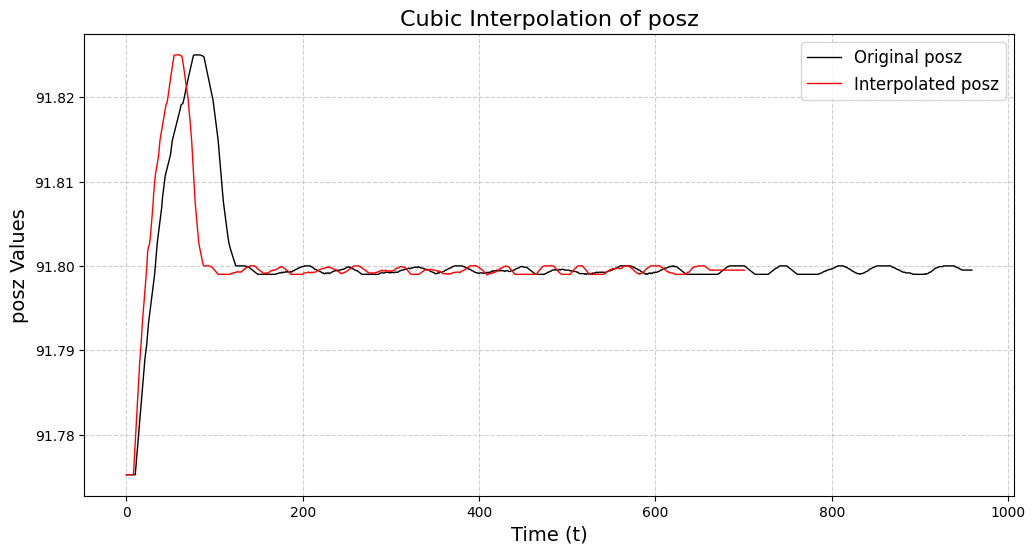

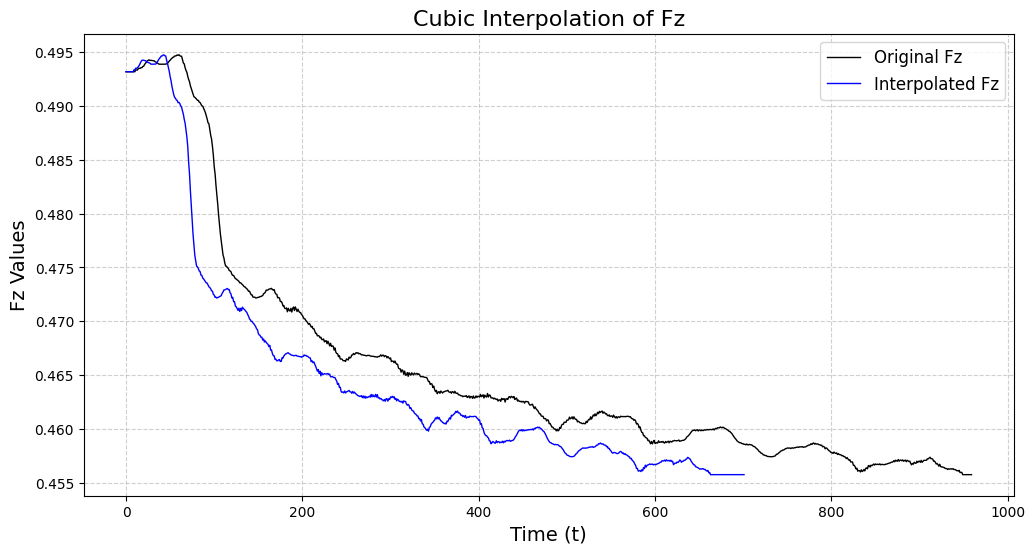

In [5]:
from matplotlib import pyplot as plt

df_original = df_list[800]
df_original = df_original.reset_index()
df_interp = padded_df[799]   # because I skipped one element above

# === First Figure: posz ===
plt.figure(figsize=(12, 6))
plt.plot(df_original['posz'], color='black', linewidth=1, label='Original posz')
plt.plot(df_interp['posz'], color='red', linewidth=1, label='Interpolated posz')

plt.xlabel('Time (t)', fontsize=14)
plt.ylabel('posz Values', fontsize=14)
plt.legend(fontsize=12)
plt.title('Cubic Interpolation of posz', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# === Second Figure: Fz ===
plt.figure(figsize=(12, 6))
plt.plot(df_original['Fz'], color='black', linewidth=1, label='Original Fz')
plt.plot(df_interp['Fz'], color='blue', linewidth=1, label='Interpolated Fz')

plt.xlabel('Time (t)', fontsize=14)
plt.ylabel('Fz Values', fontsize=14)
plt.legend(fontsize=12)
plt.title('Cubic Interpolation of Fz', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

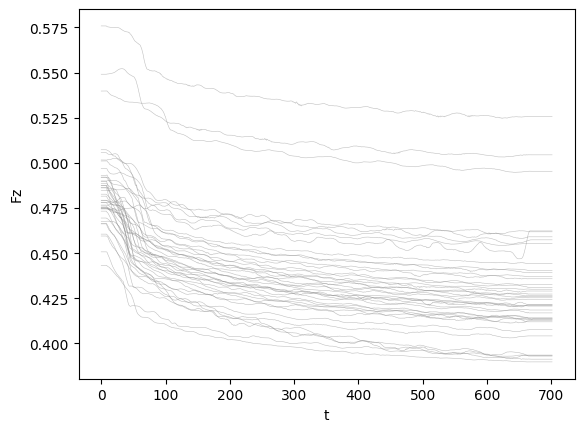

In [6]:
import random
import matplotlib.pyplot as plt

# Randomly select 40 DataFrames from df_list and add the max Energy df
sampled_dfs = random.sample(padded_df, 40)
sampled_dfs.append(padded_df[1])

fig, ax = plt.subplots()

for df in sampled_dfs:
    df.plot(y='Fz',
            color='gray',  # Set color to gray
            alpha=0.5,  # Add some transparency
            linewidth=0.4,  # Very thin lines
            legend=False,  # Don't show legend for each line
            ax=ax)  # Use the same axis

plt.xlabel('t')
plt.ylabel('Fz')
plt.show()

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models, Model


def get_auto():
    # Encoder
    encoder = tf.keras.Sequential([
        layers.Input(shape=(702, 2)),
        # Input normalization
        layers.BatchNormalization(),
        # Use 'same' padding consistently to maintain spatial dimensions
        layers.Conv1D(filters=32, kernel_size=20, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPool1D(pool_size=2),

        layers.Conv1D(filters=64, kernel_size=15, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPool1D(pool_size=2),

        layers.Conv1D(filters=96, kernel_size=10, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPool1D(pool_size=2),

        layers.Flatten(),
        layers.Dense(60, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(30, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(20, activation='linear'),
    ])

    # Decoder
    decoder = tf.keras.Sequential([
        layers.Input(shape=(20,)),
        layers.Dense(30, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(87 * 96, activation='relu'),
        layers.BatchNormalization(),
        layers.Reshape((87, 96)),

        layers.UpSampling1D(2),  # 320
        layers.Conv1DTranspose(filters=128, kernel_size=10, activation='relu', padding='same'),
        layers.BatchNormalization(),

        layers.UpSampling1D(2),  # 640
        layers.Conv1DTranspose(filters=64, kernel_size=15, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.ZeroPadding1D(padding=(0, 3)),  # Pad to reach 1286 from 1280

        layers.UpSampling1D(2),  # 1280
        layers.Conv1DTranspose(filters=32, kernel_size=20, activation='relu', padding='same'),
        layers.Conv1DTranspose(filters=2, kernel_size=20, activation='linear', padding='same'),
    ])

    return encoder, decoder


class AE(Model):
    def __init__(self, encoder: tf.keras.Sequential, decoder: tf.keras.Sequential):
        super(AE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def set_trainable(self, trainable):
        self.trainable = trainable
        self.encoder.trainable = trainable
        self.decoder.trainable = trainable


# Create the autoencoder model
autoencoder = AE(*get_auto())
autoencoder.compile(optimizer='adam', loss='mse')

# Display model summary
autoencoder.encoder.summary()
autoencoder.decoder.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 702, 2)         │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 702, 32)        │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 702, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 351, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 351, 64)        │        30,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 351, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 175, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 175, 96)        │        61,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 175, 96)        │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 87, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8352)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 60)             │       501,180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 60)             │           240 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         1,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 30)             │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │           620 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 598,398 (2.28 MB)

 Trainable params: 597,830 (2.28 MB)

 Non-trainable params: 568 (2.22 KB)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 30)             │           630 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 30)             │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8352)           │       258,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8352)           │        33,408 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 87, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 174, 96)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose                │ (None, 174, 128)       │       123,008 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 174, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 348, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_1              │ (None, 348, 64)        │       122,944 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 348, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding1d (ZeroPadding1D)  │ (None, 351, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_2 (UpSampling1D)  │ (None, 702, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_2              │ (None, 702, 32)        │        40,992 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_3              │ (None, 702, 2)         │         1,282 │
│ (Conv1DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 582,064 (2.22 MB)

 Trainable params: 564,916 (2.15 MB)

 Non-trainable params: 17,148 (66.98 KB)

(6559, 702, 2)


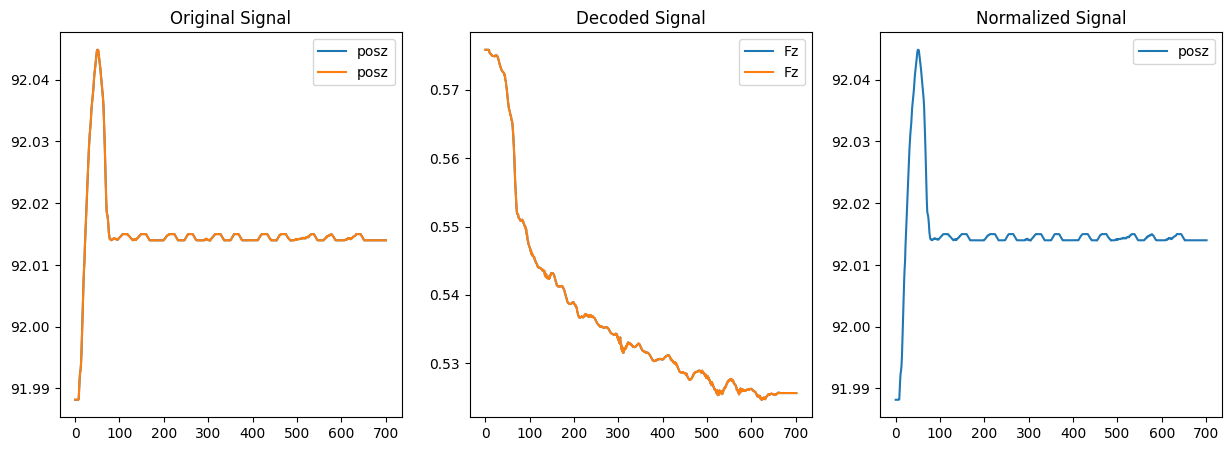

In [8]:

def create_input_signals(df_list: list[pd.DataFrame]) -> np.ndarray:
    input_signals = []

    for df in df_list:
        signal = np.column_stack((df['posz'], df['Fz']))
        
        if signal.shape != (702, 2):
            print(signal.shape) 

        # Append this signal to the list of input signals
        input_signals.append(signal)

    # Convert list to numpy array with shape (n_samples, 502, 2)
    return np.array(input_signals)


from sklearn.preprocessing import StandardScaler


# Use this instead of direct create_input_signals call
X_train = create_input_signals(padded_df)


# X_train = create_input_signals(padded_df)
print(X_train.shape)


# TEST SCALER INVERSE
SIGNAL = 1

original = X_train[SIGNAL]
sample_input = X_train[SIGNAL] 

decoded = sample_input

# Plot the original vs decoded signals for the first sample
import matplotlib.pyplot as plt

# original = all_signals[1]
# decoded = decoded_output[1]

plt.figure(figsize=(15, 5))

# Plot the original signal
plt.subplot(1, 3, 1)
plt.title("Original Signal")
plt.plot(original[:, 0], label='posz')
plt.plot(decoded[:, 0], label='posz')
plt.legend()

# Plot the decoded signal
plt.subplot(1, 3, 2)
plt.title("Decoded Signal")
plt.plot(original[:, 1], label='Fz')
plt.plot(decoded[:, 1], label='Fz')
plt.legend()

plt.subplot(1, 3, 3)
plt.title("Normalized Signal")
plt.plot(sample_input[:, 0], label='posz')
plt.legend()

plt.show()


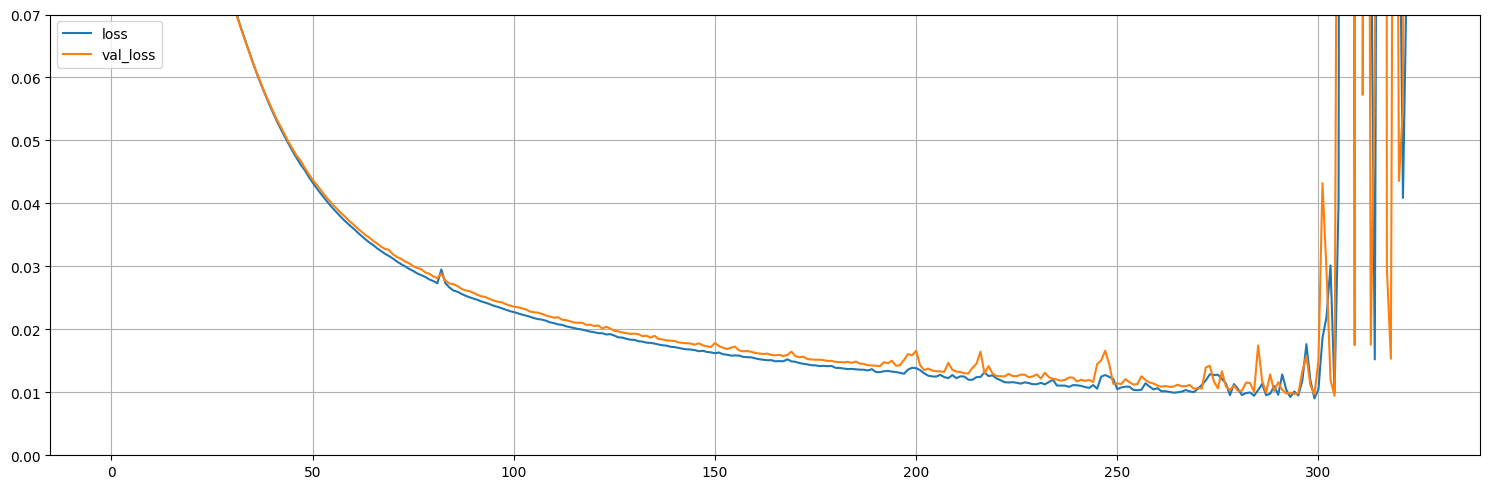

11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 947ms/step - loss: 3.8244 - val_loss: 1.0720


In [12]:
%load_ext tensorboard
import tensorflow as tf
from plot_learning import PlotLearning

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
 
log_dir = "logs/"

early_stopping = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=False, monitor="val_loss",
                                                  mode="min")
checkpoint_callback = ModelCheckpoint(filepath='weights/best_model.weights.h5', save_best_only=True, monitor="val_loss",
                                      mode='min', save_weights_only=True)
# Create TensorBoard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
autoencoder.load_weights('weights/best_model.weights.h5')

# Fit the model with TensorBoard logging
autoencoder.fit(
    X_train, X_train,
    epochs=500,
    shuffle=True,

    batch_size=512,
    verbose=1,

    validation_split=0.2,
    callbacks=[tensorboard_callback, early_stopping, checkpoint_callback, PlotLearning(autoencoder)]
)

autoencoder.load_weights('weights/best_model.weights.h5')


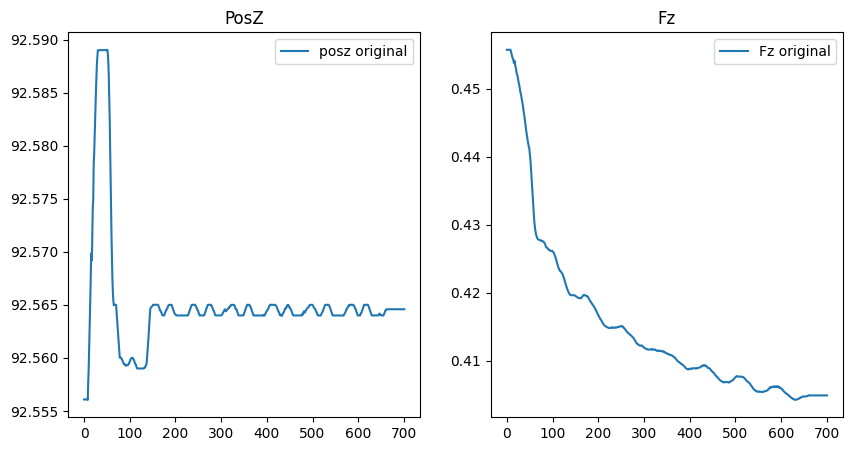

In [13]:

SIGNAL = 7

original = X_train[SIGNAL] 

sample_input = original.reshape(1, 702, 2)
reconstructed_scaled = autoencoder.predict(sample_input, verbose = 0)
decoded = decoded.reshape(702, 2)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Plot the original signal
plt.subplot(1, 2, 1)
plt.title("PosZ")
plt.plot(original[:, 0], label='posz original')
# plt.plot(decoded[:, 0], label='posz decoded')
plt.legend()

# Plot the decoded signal
plt.subplot(1, 2, 2)
plt.title("Fz")
plt.plot(original[:, 1], label='Fz original')
# plt.plot(decoded[:, 1], label='Fz decoded')
plt.legend()

plt.show()


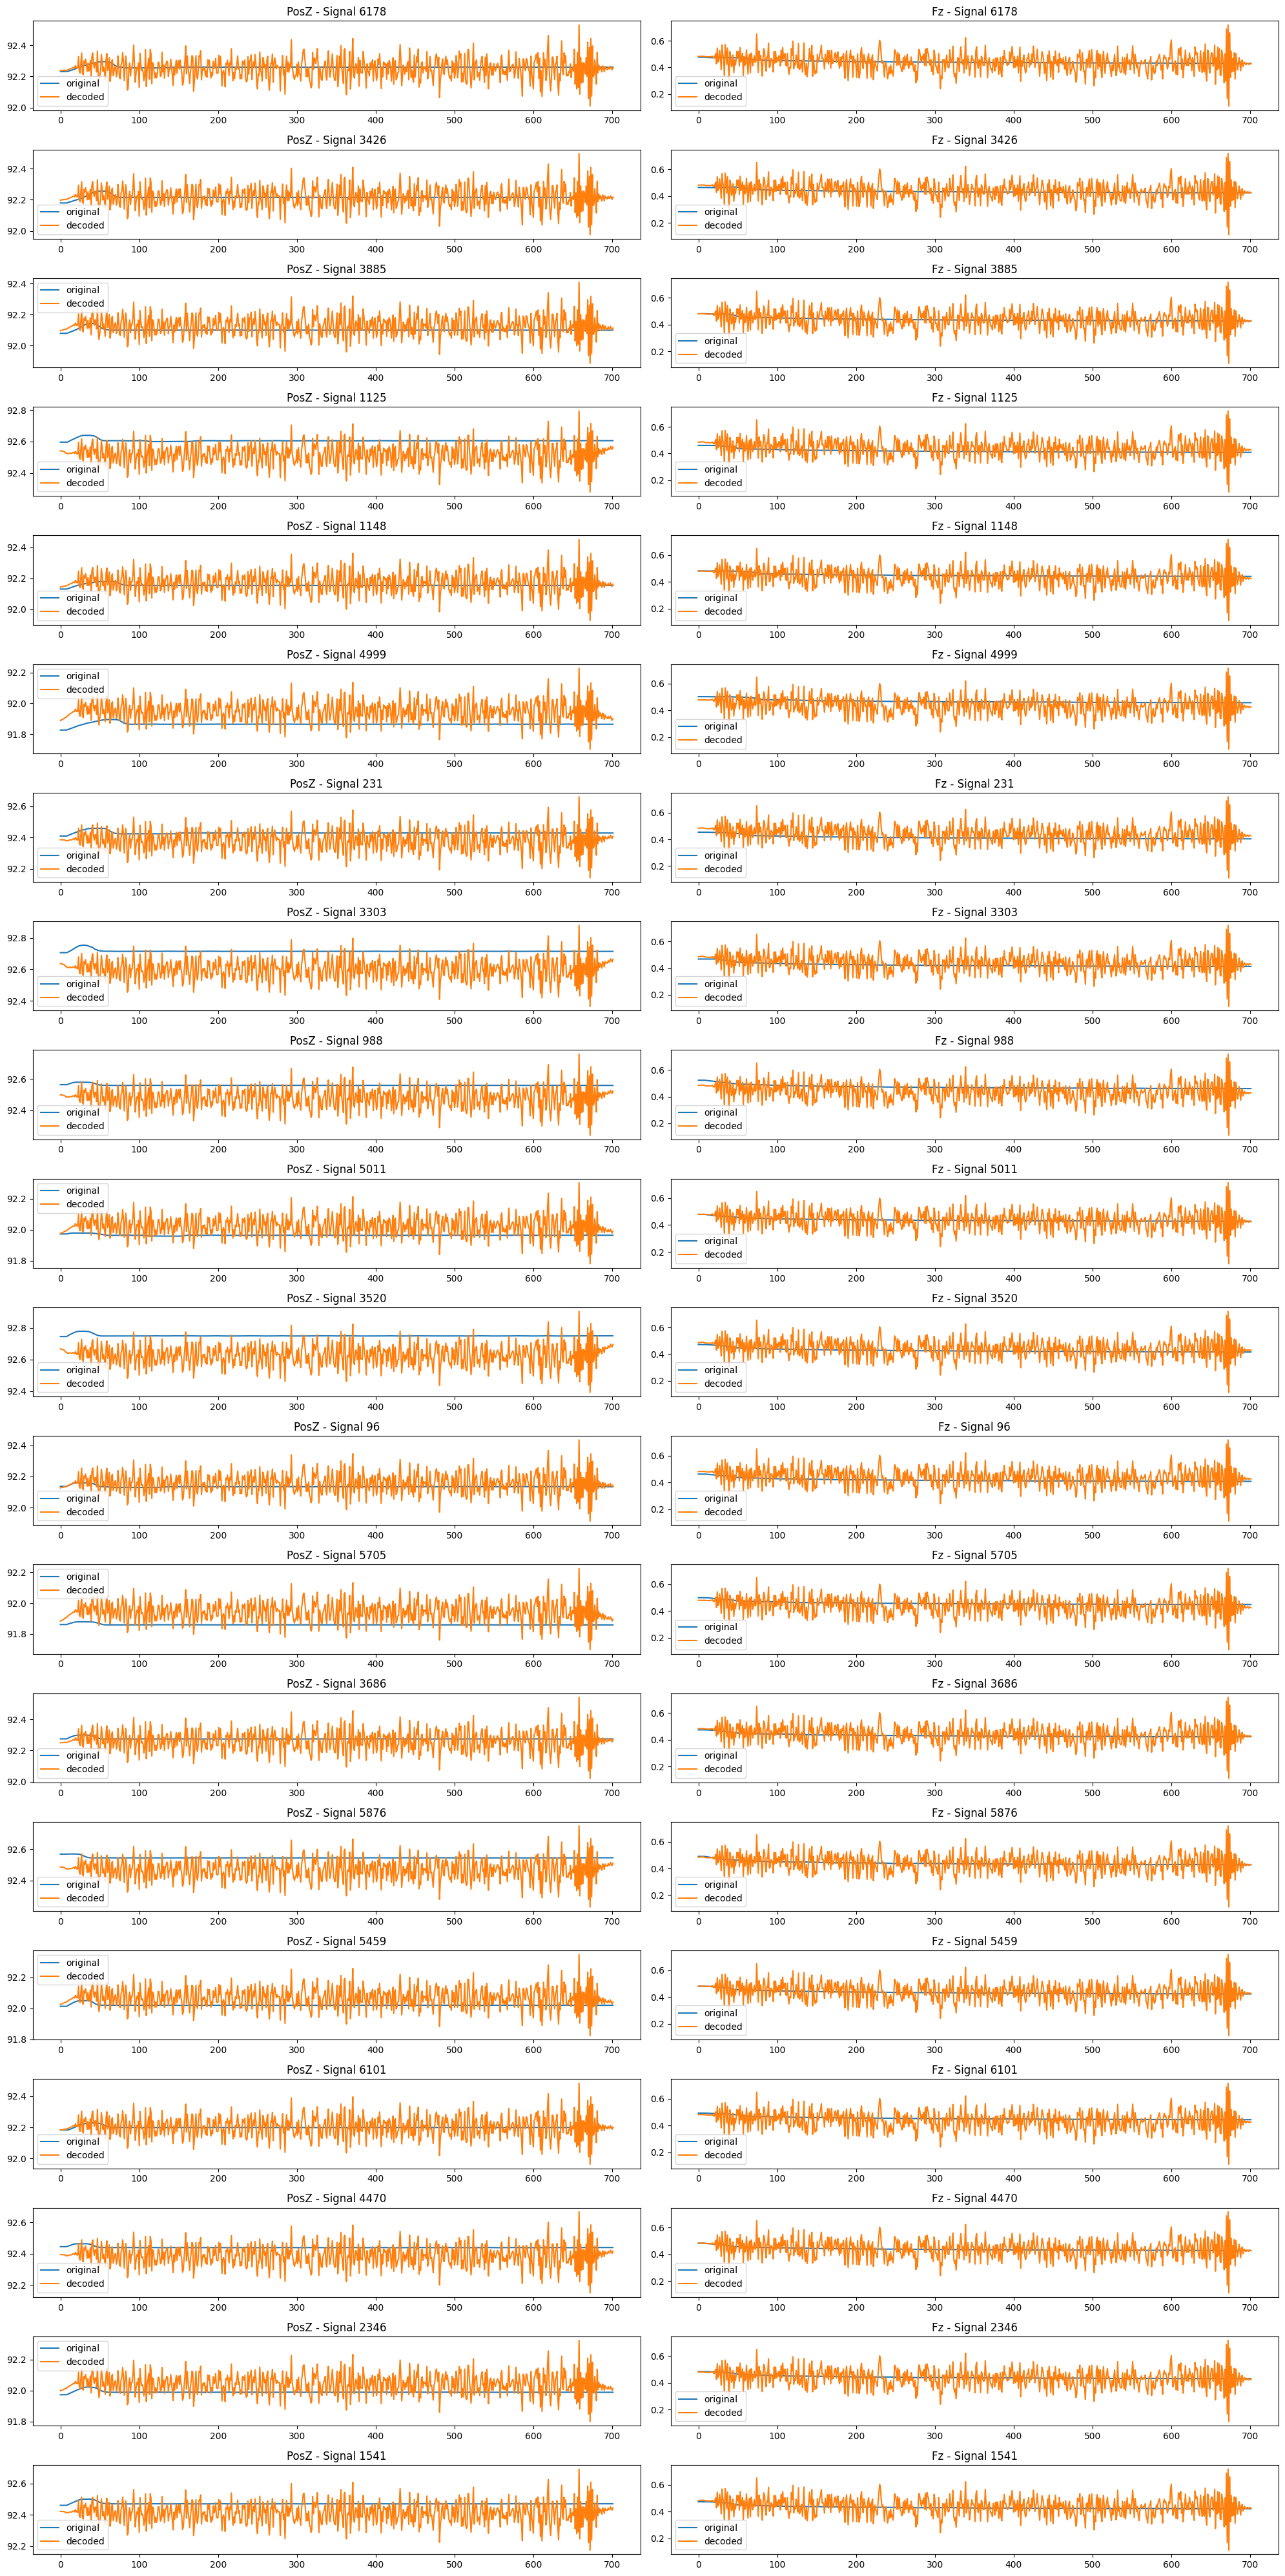

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Load the autoencoder weights
autoencoder.load_weights('weights/best_model.weights.h5')

# Number of signals to display
NUM_SIGNALS = 20

# Get random indices
random_indices = random.sample(range(len(X_train)), NUM_SIGNALS)

# Create a figure with appropriate size
plt.figure(figsize=(20, 40))

for i, idx in enumerate(random_indices):
    # Get original signal
    original = X_train[idx]
    
    # Prepare input for autoencoder
    sample_input = X_train[idx]
    sample_input = sample_input.reshape(1, 702, 2)
    
    # Get reconstruction
    reconstructed_scaled = autoencoder.predict(sample_input, verbose = 0)
    decoded = reconstructed_scaled.reshape(702, 2)
    
    # Plot PosZ
    plt.subplot(NUM_SIGNALS, 2, 2*i+1)
    plt.title(f"PosZ - Signal {idx}")
    plt.plot(original[:, 0], label='original')
    plt.plot(decoded[:, 0], label='decoded')
    plt.legend()
    
    # Plot Fz
    plt.subplot(NUM_SIGNALS, 2, 2*i+2)
    plt.title(f"Fz - Signal {idx}")
    plt.plot(original[:, 1], label='original')
    plt.plot(decoded[:, 1], label='decoded')
    plt.legend()

plt.tight_layout()
plt.show()